# Lesson 3: Model Interpretability

In [58]:
# %load_ext autoreload
# %autoreload 2

# %matplotlib inline
# import matplotlib.pyplot as plt
# import math
import ggplot

AttributeError: module 'pandas' has no attribute 'tslib'

In [1]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [2]:
import sys
import os
sys.path.insert(0, "/Users/JI/Documents/Github/fastai/old/")
# print(sys.path)
import fastai
print(sys.modules['fastai'])

<module 'fastai' from '/Users/JI/Documents/Github/fastai/courses/ml1/fastai/__init__.py'>


In [3]:
from fastai.structured import *
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import math

In [4]:
PATH = "data/bulldozers/"
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn,nas= proc_df(df_raw,'SalePrice')

In [9]:
def split_vals(a,n): return a[:n],a[n:]
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn,n_trn)
y_train, y_valid = split_vals(y_trn,n_trn)
raw_train, raw_valid = split_vals(df_raw,n_trn)
X_train.shape,y_train.shape,y_train.shape,y_valid.shape,raw_train.shape

((389125, 66), (389125,), (389125,), (12000,), (389125, 65))

In [10]:
def rmse(predicted,actual): return math.sqrt(((predicted-actual)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

### Confidence based on tree variance
take std of the average of the predictions across each of the trees

In [11]:
set_rf_samples(50_000)

In [12]:
%time
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=4)
m.fit(X_train,y_train)
print_score(m)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs
[0.2057407074244957, 0.24803395204979836, 0.9115342255719685, 0.8901322475489909]


In [13]:
%time
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [14]:
X_valid

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
389125,4364751,2300944,665,172,1.0,1999,3726.0,2,3232,1111,...,259,False,False,False,False,False,False,1284595200,False,False
389126,4364757,1265434,12042,172,1.0,1996,5809.0,2,3234,1112,...,343,False,False,False,False,False,False,1291852800,False,False
389127,4364774,2005935,9218,172,1.0,1993,0.0,-1,3238,1115,...,218,False,False,False,False,False,False,1281052800,False,False
389128,4364807,2296707,668,172,1.0,2000,1789.0,2,3242,1116,...,349,False,False,False,False,False,False,1292371200,False,False
389129,4364811,1403366,9219,172,1.0,1999,0.0,-1,3241,1116,...,161,False,False,False,False,False,False,1244592000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,1840702,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401121,6333337,1830472,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401122,6333338,1887659,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401123,6333341,1903570,21435,149,2.0,2005,0.0,-1,483,159,...,298,False,False,False,False,False,False,1319500800,False,True


#### predictions
- val set contains 12k rows (obsv) with 66 features
- preds takes the predictions of each of the 40 specificed trees (n_estimators)
    - 40 rows for each tree, 12k cols (each tree contains the average value of each of the 12k obs in the validation set
    

In [15]:
display(preds.shape,preds)

(40, 12000)

array([[9.2362 , 9.3455 , 9.29522, ..., 9.30352, 9.31191, 9.31191],
       [9.04274, 9.18989, 9.03787, ..., 9.30496, 9.25609, 9.25609],
       [9.03119, 9.05458, 9.3797 , ..., 9.71858, 9.0676 , 9.0676 ],
       ...,
       [9.28131, 9.10498, 9.01156, ..., 9.69705, 9.48296, 9.48296],
       [9.09199, 9.20299, 9.14414, ..., 9.20783, 9.59069, 9.59069],
       [9.16986, 9.11002, 9.24128, ..., 9.19911, 9.72702, 9.72702]])

In [16]:
display(np.mean(preds[:,0])) # the mean of all the trees, for the 1st observation
display(np.std(preds[:,0])) # the std of all the trees, for the 1st observation

9.199231037798423

0.22683973572182478

#### Parallelize the predictions operation

In [17]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 105 ms, sys: 79.6 ms, total: 185 ms
Wall time: 1.46 s


(9.199231037798423, 0.22683973572182478)

In [18]:
raw_valid 

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
389125,4364751,9.104980,2300944,665,172,1.0,1999,3726.0,2,KX1212,...,16,3,259,False,False,False,False,False,False,1284595200
389126,4364757,9.047821,1265434,12042,172,1.0,1996,5809.0,2,KX151,...,9,3,343,False,False,False,False,False,False,1291852800
389127,4364774,9.104980,2005935,9218,172,1.0,1993,0.0,-1,KX41,...,6,4,218,False,False,False,False,False,False,1281052800
389128,4364807,9.259131,2296707,668,172,1.0,2000,1789.0,2,KX612,...,15,2,349,False,False,False,False,False,False,1292371200
389129,4364811,9.104980,1403366,9219,172,1.0,1999,0.0,-1,KX61,...,10,2,161,False,False,False,False,False,False,1244592000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


#### Visualize confidence intervals by columns
- looking to see which cols contain data, etc

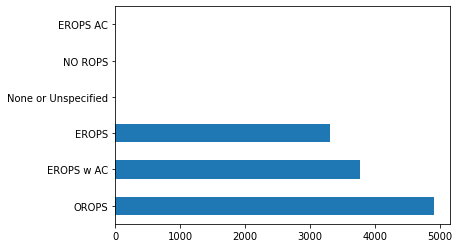

In [19]:
valid_copy = raw_valid.copy()
valid_copy['pred_std'] = np.std(preds, axis=0) # down all the trees
valid_copy['pred'] = np.mean(preds, axis=0)
valid_copy.Enclosure.value_counts().plot.barh();

##### Side note - seeing how axis=0, and axis=1 affect things
- axis=0 down rows
- axis=1 across cols

In [20]:
test = np.array([[1,1],[2,2]])
test

array([[1, 1],
       [2, 2]])

In [21]:
axis0 = np.mean(test,axis=0)
axis1 = np.mean(test,axis=1)
axis0, axis0.shape, axis1, axis1.shape

(array([1.5, 1.5]), (2,), array([1., 2.]), (2,))

#### see how Enclosure and SalePrice are related

In [22]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = valid_copy[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.842070,0.275690
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574768,0.268658
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685857,0.221792


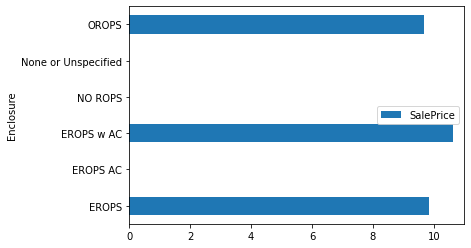

In [23]:
# enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

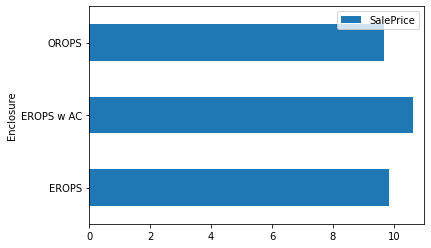

In [24]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

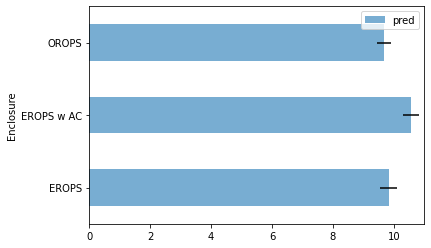

In [25]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

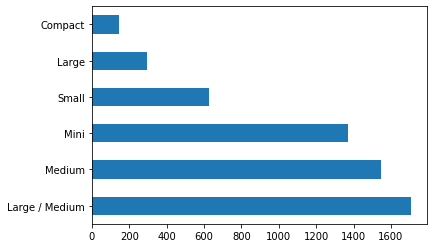

In [26]:
raw_valid.ProductSize.value_counts().plot.barh();

In [27]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = valid_copy[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.856881,0.352099
Large,10.470589,10.371027,0.370879
Large / Medium,10.691871,10.647051,0.298716
Medium,10.681511,10.613912,0.291799
Mini,9.535147,9.564968,0.251276
Small,10.324448,10.321916,0.318223


In [28]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.035761
Compact           0.035721
Small             0.030830
Large / Medium    0.028056
Medium            0.027492
Mini              0.026270
dtype: float64

### Feature Importance
- which columns matter
- Data Leakage: having access to information during model development that you wouldn't have during actual decision making
- look at top10 features and try to understand more deeply
- removing reduntant cols might make predictions a little bit better, also removing colinearity (cols related to each other)
- Feature Importance: take one col and randomly shuffle so it has no relationship to the dependent variable. Then run predictions on the trained model

In [29]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.175135
13,ProductSize,0.107725
37,Coupler_System,0.090084
14,fiProductClassDesc,0.076252
39,Hydraulics_Flow,0.052184
63,saleElapsed,0.051502
2,ModelID,0.049792
10,fiSecondaryDesc,0.046273
38,Grouser_Tracks,0.039161
19,Enclosure,0.035834


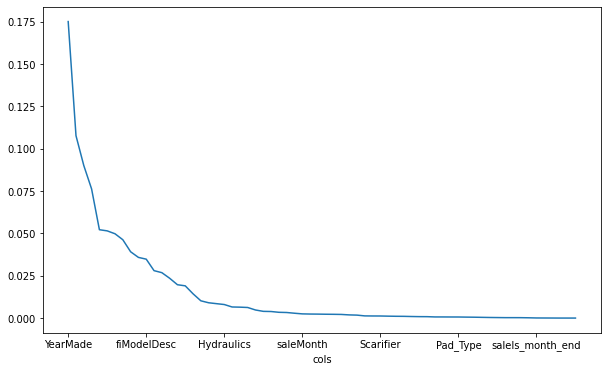

In [30]:
fi.plot('cols','imp',figsize=(10,6),legend=False)

In [31]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

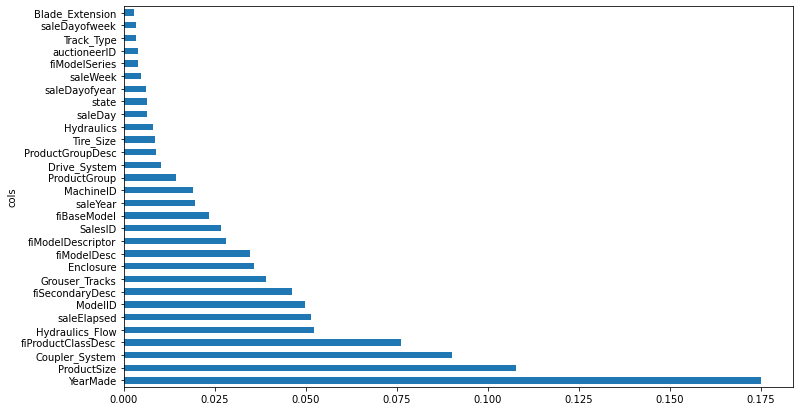

In [32]:
plot_fi(fi[:30])

In [33]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [34]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [35]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=4)
m.fit(X_train,y_train)
print_score(m)

[0.2067176494621346, 0.2463325225578763, 0.9106920866674311, 0.8916343893853246]


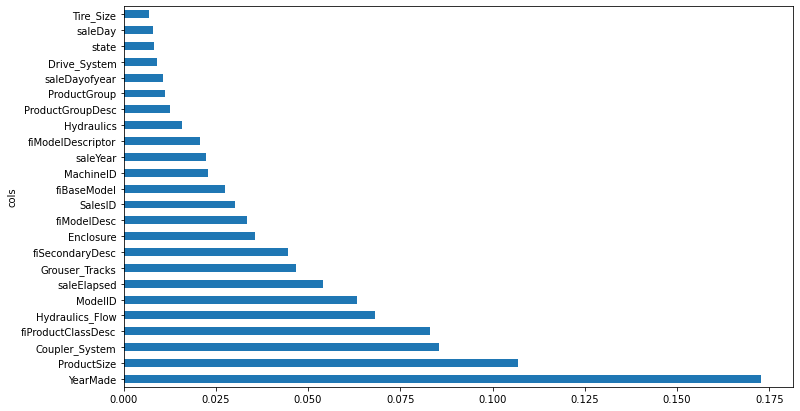

In [36]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

### Important hyperparameters

- **set_rf_samples** - how many samples in each tree
- depth of the tree is log_base2(sample_size) b/c binary decision
- linear relationship b/w # of leaf nodes and size of sample
- **min_samples_leaf**, each time we double we remove one layer from the tree, so with 2 leafs, would be log_base2(sample_size)-1
- **max_features**: at each split point in a tree we take the specified # of features

### Validation set diagnostic
 - Two reasons why val set might not be as good as the training set
     1. model is overfitting, either use OOB score or use a 2nd val set randomly sampled - if those get much worse, overfitting
     2. asdf
     

### one-hot encoding
- use it to see how model's feature importances change. Model may or may not improve.
- use max_n_cat to set the limilt on number of categories per feature

In [37]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2072867355353339, 0.25331761065725256, 0.910199687029718, 0.8854015509488143, 0.8924535289284353]


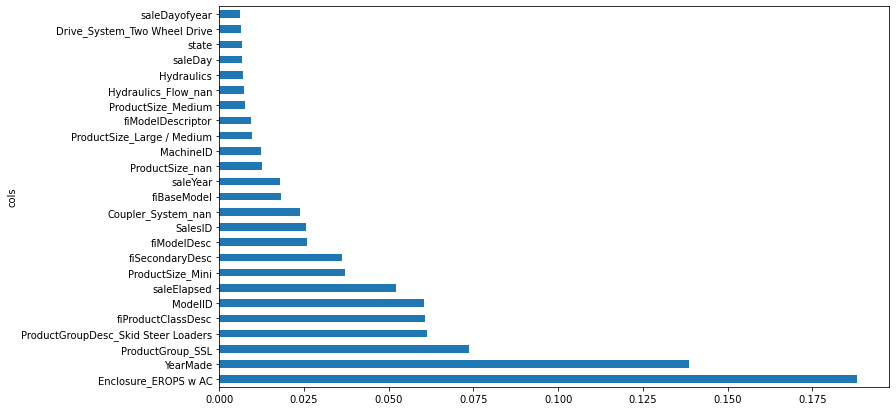

In [38]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

### Remove redundant features
- dendrogram, type of hierarchical clustering
    - find which ones are similar to each other
- correlation: similar to R^2
    - between two variables (R^2 is between a variable and its prediciton)
- problem with normal correlation: assumes linearity
- solution: rank correlation
    - replace every point by its rank
    - new plot of rank of data (order in the dataset), can look linear that way (data has to be monotonic)
    - RFs don't care about linearity, only care about order

In [39]:
from scipy.cluster import hierarchy as hc

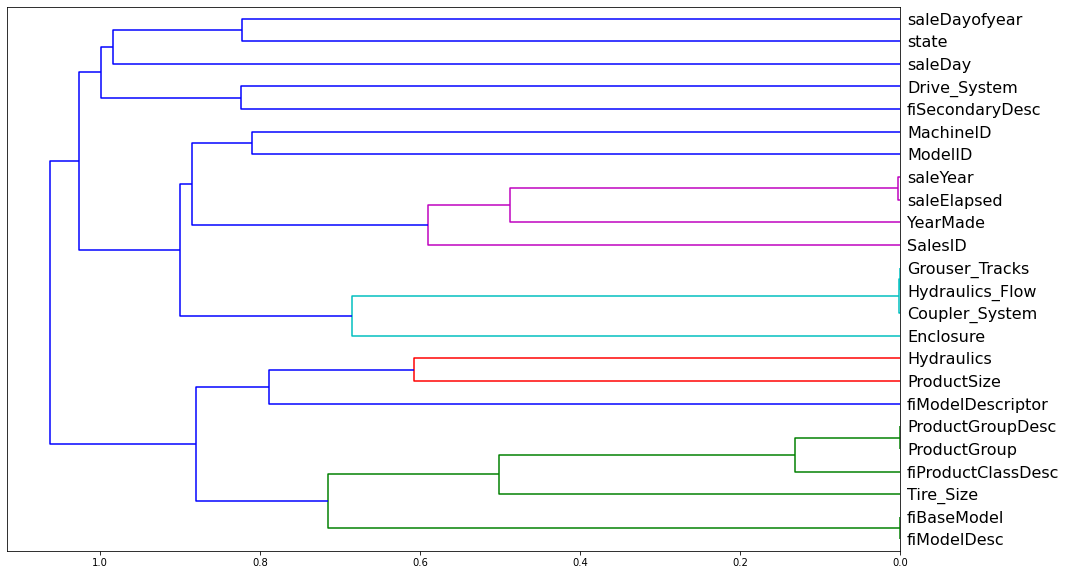

In [40]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
# correlation matrix to dendrogram, distance matrix to dendrogram
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

#### which features can we remove without making baseline oob score worse?

In [41]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [42]:
get_oob(df_keep)

0.8903712572666524

In [43]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8894647259176802
saleElapsed 0.8868501011250597
fiModelDesc 0.8891282802505289
fiBaseModel 0.8889589980695196
Grouser_Tracks 0.8898852288858016
Coupler_System 0.8901232981910808


In [44]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8889298507128032

**so dropping one from each set doesn't make much of a difference in oob_score.so drop those, and get a simpler model**

In [45]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [46]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [47]:
keep_cols = np.load('tmp/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

**test model on full dataset**

In [48]:
reset_rf_samples()

In [49]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12575640751387282, 0.2260527484420391, 0.9669482034473474, 0.9087427121546936, 0.9087696482954384]


### Partial Dependence
- find out for the features that are important, how do they relate to the dependent variable

In [51]:
from pdpbox import pdp
# from plotnine import *

In [52]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [53]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

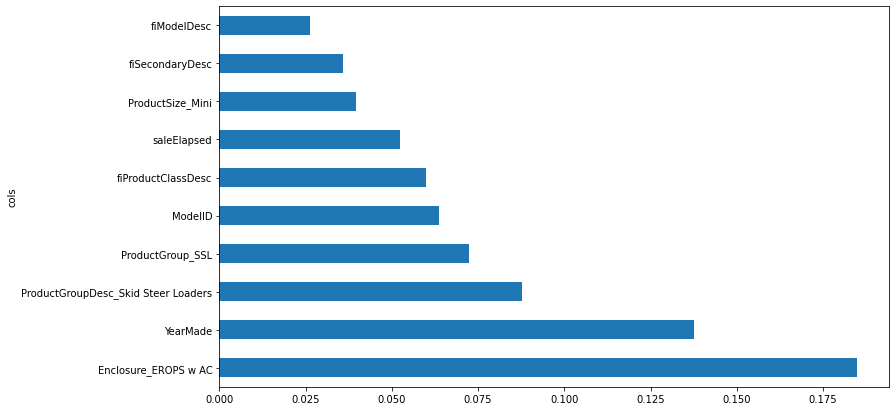

In [54]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

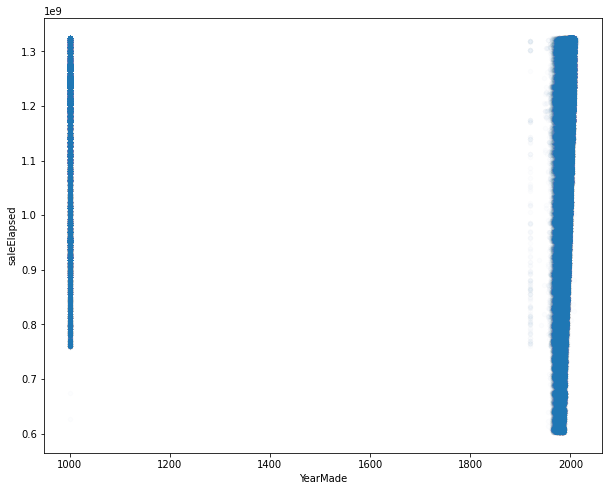

In [55]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

**interesting above, can't have year 1000 prolly records that dont have data and were filled in with some number

In [56]:
# get sample gets a random sample, better for plotting
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

**after removing year made of anything less than 1930 (for analysis), look at relationship b/w YearMade and SalePrice**

In [57]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

NameError: name 'ggplot' is not defined

**why is there a dip between 1990 and 2000? would expect the price to be going up. but there could have been the same number of units sold, but lower price for some reason, etc. etc. (usually there is something else that happened)**
- what's relationship b/w SalePrice and YearMade all other things being equal?
- **solution**: partial dependence plot

In [59]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [60]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [61]:
plot_pdp('YearMade')

TypeError: pdp_isolate() missing 1 required positional argument: 'feature'